In [9]:
!kaggle datasets download -d ashfakyeafi/cat-dog-images-for-classification


Dataset URL: https://www.kaggle.com/datasets/ashfakyeafi/cat-dog-images-for-classification
License(s): CC0-1.0
 99% 537M/545M [00:05<00:00, 56.2MB/s]
100% 545M/545M [00:05<00:00, 102MB/s] 


In [10]:
import zipfile
zip_ref = zipfile.ZipFile('/content/cat-dog-images-for-classification.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [11]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,BatchNormalization,Dropout,GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers
import shutil
import os


In [12]:
source_dir = '/content/cat_dog'

cat_dir = '/content/cat_dog/cat'
dog_dir = '/content/cat_dog/dog'

os.makedirs(cat_dir, exist_ok=True)
os.makedirs(dog_dir, exist_ok=True)

for filename in os.listdir(source_dir):
    if os.path.isfile(os.path.join(source_dir, filename)) and filename.startswith("cat"):
        shutil.move(os.path.join(source_dir, filename), os.path.join(cat_dir, filename))
    elif os.path.isfile(os.path.join(source_dir, filename)) and filename.startswith("dog"):
        shutil.move(os.path.join(source_dir, filename), os.path.join(dog_dir, filename))

 **Data Preprocessing**

In [13]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/cat_dog',
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset='training'
)

val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/cat_dog',
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset='validation'
)


Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [14]:
def process(image,label):
  image = tf.cast(image/255. ,tf.float32)
  return image,label

train_dataset = train_dataset.map(process)
val_dataset = val_dataset.map(process)

**CNN Model**

In [15]:
model = Sequential()

model.add(Conv2D(32,kernel_size=(3,3),padding='valid',activation='relu',input_shape=(256,256,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model.add(Conv2D(64,kernel_size=(3,3),padding='valid',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model.add(Conv2D(128,kernel_size=(3,3),padding='valid',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))



model.add(Flatten())


model.add(Dense(128,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1,activation='sigmoid'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [16]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 254, 254, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 125, 125, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 60, 60, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 115200)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      14,745,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,848,193 (56.64 MB)

 Trainable params: 14,847,745 (56.64 MB)

 Non-trainable params: 448 (1.75 KB)

**Compile the Model**

In [17]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

**Training the Model**

In [18]:
history = model.fit(train_dataset,epochs=7,validation_data=val_dataset)

Epoch 1/7
625/625 ━━━━━━━━━━━━━━━━━━━━ 65s 85ms/step - accuracy: 0.5592 - loss: 3.0413 - val_accuracy: 0.6318 - val_loss: 0.6482
Epoch 2/7
625/625 ━━━━━━━━━━━━━━━━━━━━ 68s 78ms/step - accuracy: 0.6730 - loss: 0.6132 - val_accuracy: 0.7036 - val_loss: 0.5779
Epoch 3/7
625/625 ━━━━━━━━━━━━━━━━━━━━ 53s 85ms/step - accuracy: 0.7393 - loss: 0.5254 - val_accuracy: 0.7410 - val_loss: 0.5294
Epoch 4/7
625/625 ━━━━━━━━━━━━━━━━━━━━ 78s 79ms/step - accuracy: 0.7894 - loss: 0.4542 - val_accuracy: 0.7554 - val_loss: 0.6895
Epoch 5/7
625/625 ━━━━━━━━━━━━━━━━━━━━ 49s 79ms/step - accuracy: 0.8299 - loss: 0.3870 - val_accuracy: 0.6228 - val_loss: 1.0800
Epoch 6/7
625/625 ━━━━━━━━━━━━━━━━━━━━ 86s 85ms/step - accuracy: 0.8540 - loss: 0.3433 - val_accuracy: 0.8052 - val_loss: 0.5172
Epoch 7/7
625/625 ━━━━━━━━━━━━━━━━━━━━ 50s 80ms/step - accuracy: 0.8963 - loss: 0.2479 - val_accuracy: 0.7758 - val_loss: 0.5735


**Plotting Accuracy and Loss**

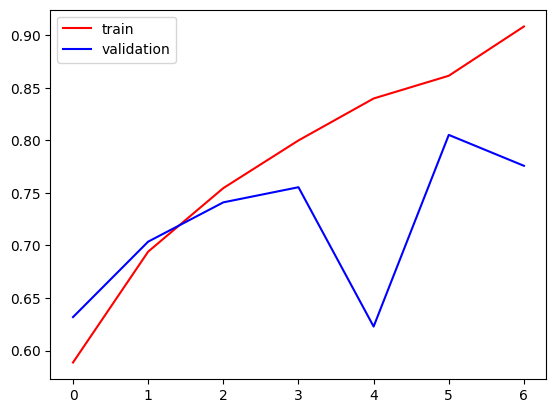

In [19]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'],color ='red',label ='train')
plt.plot(history.history['val_accuracy'],color ='blue',label ='validation')
plt.legend()
plt.show()



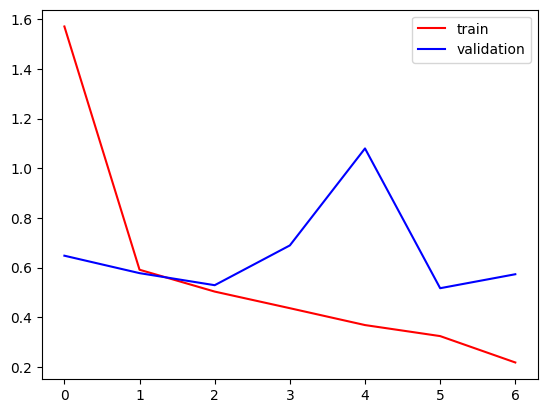

In [20]:
plt.plot(history.history['loss'],color ='red',label ='train')
plt.plot(history.history['val_loss'],color ='blue',label ='validation')
plt.legend()
plt.show()